**IMPLEMENTATION OF CNN+GNN HYBRID MODEL FOR EARLY DISEASE DETECTION AND DIAGNOSIS OF PARKINSON'S DISEASE**

**STAGE 1:CNN feature extraction from preprocessed brain MRI images.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.layers import UpSampling2D

1. os: This module provides functions to interact with the operating system. It allows you to perform tasks such as navigating directories, creating or deleting files, etc.
2. numpy as np: NumPy is a library in Python used for numerical computing.
3. tensorflow as tf: TensorFlow is an open-source machine learning framework widely used for building and training various machine learning models, particularly neural networks.
4. from tensorflow.keras.preprocessing.image import img_to_array, load_img:These functions are used for converting images to arrays and loading images from files, respectively.
5. from tensorflow.keras.applications import ResNet50: This imports the ResNet50 model, which is a pre-trained convolutional neural network (CNN) available in Keras
6. from tensorflow.keras.models import Model: This imports the Model class from the Keras models module. The Model class is used to define and construct deep learning models in Keras.
7. from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, UpSampling2D: This imports specific layer classes from the Keras layers module. These layers are commonly used in convolutional neural networks for tasks such as image segmentation or reconstruction. Conv2D and Conv2DTranspose are convolutional layers for feature extraction and upsampling, respectively.UpSampling2D is used for upsampling the input.

**Upsampling is necessary in tasks such as image segmentation to increase the spatial resolution of feature maps, enabling finer details to be preserved in the output. It helps in recovering spatial information lost during downsampling operations like pooling or convolution, thereby improving the quality and accuracy of the model's predictions.**

In [ ]:
preprocessed_images_path = '/content/drive/MyDrive/preprocessed_images'
output_file = '/content/drive/MyDrive/extracted_features.npy'


**This above code defines two variables: preprocessed_images_path stores the directory path where preprocessed images are located, typically used as input for a Deep learning model. output_file specifies the file path where the extracted features will be saved, commonly in the form of a NumPy array file (.npy), often used for analysis or further processing.**

In [ ]:
def build_unet_resnet50(input_shape):
    # Load pre-trained ResNet50 model without the top (classification) layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Encoder
    encoder = base_model.get_layer('conv5_block3_out').output

    # Decoder
    decoder = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)
    decoder = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(decoder)
    decoder = Concatenate()([decoder, base_model.get_layer('conv4_block6_out').output])
    decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(decoder)
    decoder = Concatenate()([decoder, base_model.get_layer('conv3_block4_out').output])
    decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(decoder)
    decoder = Concatenate()([decoder, base_model.get_layer('conv2_block3_out').output])
    decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(decoder)
    decoder = Concatenate()([decoder, base_model.get_layer('conv1_relu').output])
    decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(1, (1, 1), activation='sigmoid')(decoder)  # Output mask

    # Combine encoder and decoder into a single model
    model = Model(inputs=base_model.input, outputs=decoder)

    return model

**This code defines a function build_unet_resnet50 that constructs a U-Net architecture with a ResNet50 backbone for image segmentation tasks.**


1. **Load Pre-trained ResNet50 Model**:The code loads the pre-trained ResNet50 model without its top (classification) layer. This model serves as the backbone for feature extraction.
2. **Encoder:** The encoder is responsible for capturing high-level features from the input image.In this code, the encoder portion is essentially the pre-trained ResNet50 model, which has already been trained on a large dataset for image classification tasks.It processes the input image through a series of convolutional and pooling layers, gradually extracting hierarchical features at different levels of abstraction.
3.** Decoder:** The decoder part is responsible for gradually upsampling the features extracted by the encoder to generate the final segmentation mask.It reconstructs the spatial information lost during the encoding process and refines the feature representations to produce a detailed segmentation map.

This architecture effectively combines the powerful feature extraction capabilities of ResNet50.





In [ ]:
input_shape = (224, 224, 3)
unet_resnet50_model = build_unet_resnet50(input_shape)

1. input_shape = (224, 224, 3): This line defines the input shape for the images that the model will process.
2. unet_resnet50_model = build_unet_resnet50(input_shape): This line creates a U-Net model with a ResNet50 backbone using the function build_unet_resnet50, passing the input_shape as an argument.



In [ ]:
pd_images = []
for i in range(1, 907):  # Assuming images are named PD_1.png to PD_906.png
    filename = f'PD_{i}.png'
    image_path = os.path.join(preprocessed_images_path, filename)
    img = load_img(image_path, target_size=(input_shape[0], input_shape[1]))
    img_array = img_to_array(img)
    pd_images.append(img_array)

# Load and preprocess normal images
normal_images = []
for i in range(1, 177):  # Assuming images are named normal_001.png to normal_176.png
    filename = f'normal_{i:03d}.png'
    image_path = os.path.join(preprocessed_images_path, filename)
    img = load_img(image_path, target_size=(input_shape[0], input_shape[1]))  # Adjusted target size to match PD images
    img_array = img_to_array(img)
    normal_images.append(img_array)

This code is responsible for loading and preprocessing images from the specified directory paths (preprocessed_images_path) and converted as converted to a NumPy array .

Images are converted into NumPy arrays because most machine learning and deep learning frameworks, including TensorFlow and Keras, typically work with numerical data, particularly arrays or tensors. Converting images into NumPy arrays allows them to be efficiently processed and manipulated using array operations, which are optimized for performance.

In [ ]:
pd_images = np.array(pd_images) / 255.0
normal_images = np.array(normal_images) / 255.0

This code normalizes the pixel values of the image data stored in the pd_images and normal_images NumPy arrays.

This code ensures that the pixel values of both the PD and normal images are scaled to a standardized range, which is a common preprocessing step in machine learning tasks, particularly when working with image data. Normalizing the pixel values helps stabilize the training process and improves the convergence of neural network models during training.






In [ ]:
all_images = np.concatenate((pd_images, normal_images), axis=0)

features = unet_resnet50_model.predict(all_images, verbose=1)

np.save(output_file, features)

34/34 [==============================] - 319s 9s/step


This code concatenates the preprocessed PD and normal images into a single array, then feeds this combined array into a U-Net model with a ResNet50 backbone (unet_resnet50_model) to generate segmentation features. Finally, it saves these features into a NumPy file (output_file) for further analysis or use in downstream tasks.

**STAGE 2: GNN-based graph construction using the extracted features.**

In [ ]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle

1. import networkx as nx: NetworkX is a Python library for the creation, manipulation, and study of complex networks or graphs, providing tools for analyzing graph structures and algorithms for various graph-related tasks.
2. from sklearn.metrics.pairwise import cosine_similarity: Scikit-learn's cosine_similarity calculates the cosine similarity between vectors, commonly used in information retrieval, document similarity analysis, and recommendation systems.
3. import matplotlib.pyplot as plt: Matplotlib is a plotting library in Python used to create static, interactive, and animated visualizations in various formats, offering a wide range of customization options for data visualization.
4. import pickle used to save the graph generated.





In [ ]:
features = np.load('/content/drive/MyDrive/extracted_features.npy')

This code loads a NumPy array named features from a file located at the specified path '/content/drive/MyDrive/extracted_features.npy'.

In [ ]:
def construct_graph(features, threshold=0.8):
    num_samples = features.shape[0]
    graph = nx.Graph()

    # Add nodes to the graph
    graph.add_nodes_from(range(num_samples))

    # Compute cosine similarity between features
    similarity_matrix = cosine_similarity(features.reshape(num_samples, -1))

    # Add edges to the graph based on similarity threshold
    for i in range(num_samples):
        for j in range(i + 1, num_samples):
            similarity_score = similarity_matrix[i, j]
            if similarity_score >= threshold:
                graph.add_edge(i, j, weight=similarity_score)

    return graph


The purpose of the above  code is to construct a graph representation of data points based on their feature similarities, using cosine similarity as a measure.
1. **def construct_graph(features, threshold=0.8):**This function is defined to construct a graph representation from a set of features.It takes two parameters: features, which is a NumPy array containing the features of data points, and threshold, which is a similarity threshold used to determine whether to connect two data points with an edge in the graph. The default threshold is set to 0.8.
2. **num_samples = features.shape[0]:** Calculates the number of samples or data points in the provided features array.
3. **graph = nx.Graph():** Initializes an empty graph using NetworkX, which will store the relationships between data points based on their similarities.
4. **graph.add_nodes_from(range(num_samples))** : Adds nodes to the graph, with each node representing a data point. The number of nodes added corresponds to the number of samples in the features array.
5. **similarity_matrix = cosine_similarity(features.reshape(num_samples, -1):**  Computes the cosine similarity between pairs of feature vectors using the cosine_similarity function and Reshapes the features array into a 2D array where each row represents a data point and each column represents a feature dimension.
6. **for i in range(num_samples): for j in range(i + 1, num_samples):**  Iterates over pairs of data points in a nested loop, ensuring that each pair is considered only once to avoid redundant computations.
7. **similarity_score = similarity_matrix[i, j]:** Retrieves the cosine similarity score between the features of data points i and j from the similarity matrix.
8. ** if similarity_score >= threshold:graph.add_edge(i,weight=similarity_score):** Adds an edge between data points i and j in the graph if their similarity score exceeds or equals the specified threshold.
The weight of the edge is set to the similarity score, indicating the strength of the connection between the two data points.
9. **return graph:** Returns the constructed graph, which represents the relationships between data points based on their feature similarities.












In [ ]:
graph = construct_graph(features)

The purpose of this code is to construct a graph representation of a dataset using the provided features.

In [ ]:
with open('/content/drive/MyDrive/graph.pkl', 'wb') as f:
    pickle.dump(graph, f)

# Load the graph
with open('/content/drive/MyDrive/graph.pkl', 'rb') as f:
    graph = pickle.load(f)

The purpose of the above  code is to save the constructed graph object (graph) to a file using pickle serialization (pickle.dump()), and then load the saved graph object from the file (pickle.load()) for later use or analysis, facilitating storage and retrieval of the graph structure.

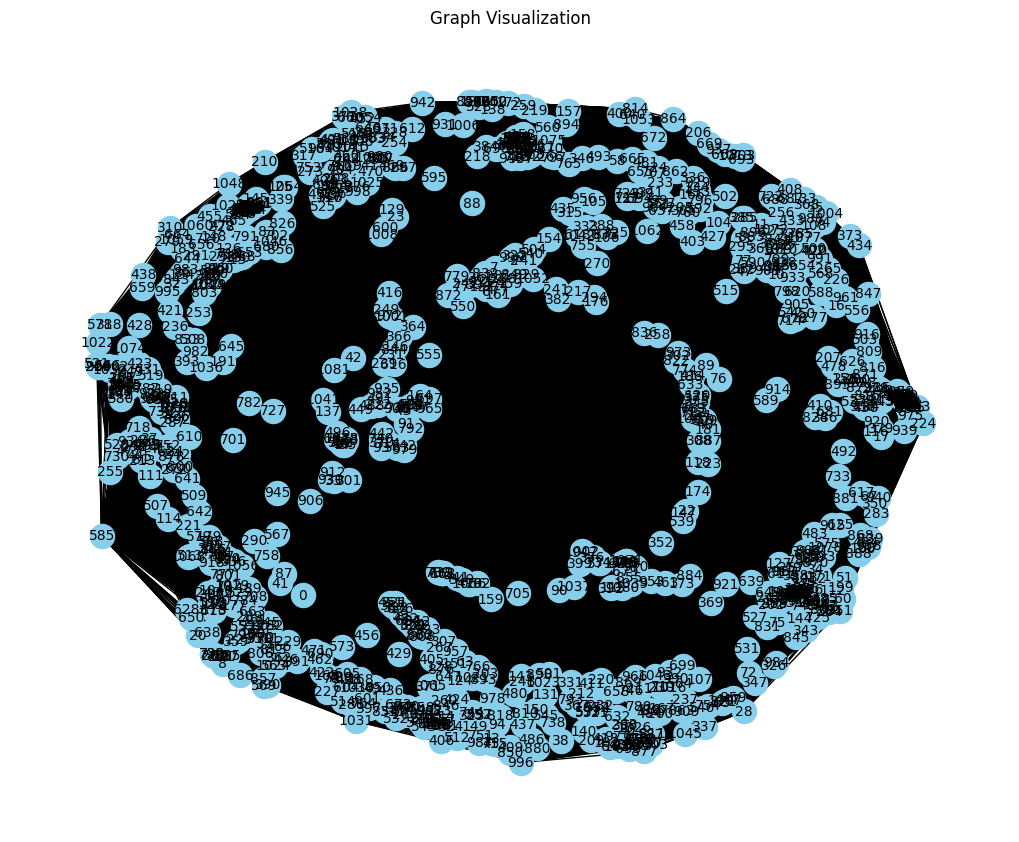

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Positions nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(graph, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=10)
plt.title('Graph Visualization')
plt.show()

The purpose of this code is to visualize the constructed graph (graph) using NetworkX and Matplotlib, displaying the nodes and edges with labeled nodes, customizable node size and color, and a title, facilitating visual exploration and analysis of the graph structure.

**STAGE 3:Integration of CNN features and GNN graph representation into a hybrid model AND Training and evaluation of the hybrid model for Parkinson's disease detection and diagnosis.**

In [ ]:
import numpy as np
import networkx as nx
import tensorflow as tf
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

1. **from tensorflow.keras.models import Model:** Importing the Model class from TensorFlow Keras allows for building and manipulating neural network models, enabling the construction of custom architectures for various machine learning tasks.
2. **from tensorflow.keras.layers import Input,Dense,Flatten,concatenate: ** These imports bring in specific layer classes from TensorFlow Keras, such as Input, Dense, Flatten, and concatenate, which are essential for defining the structure and behavior of neural network models.
3. **from sklearn.model_selection import train_test_split:** This import from scikit-learn enables the splitting of dataset into training and testing subsets, facilitating model evaluation and validation by ensuring separation between training and testing data.
4. **from sklearn.metrics import accuracy_score:** Importing accuracy_score from scikit-learn provides a metric for evaluating classification models, measuring the accuracy of predicted labels against true labels, thus assessing the model's performance.





In [ ]:
features = np.load('/content/drive/MyDrive/extracted_features.npy')

with open('/content/drive/MyDrive/graph.pkl', 'rb') as f:
    graph = pickle.load(f)

The above code loads the feature extracted in stage 1 and loads graph constructed in stage 2.

In [ ]:
adj_matrix = nx.to_numpy_array(graph)


The purpose of this code is to convert the graph (graph) into its corresponding adjacency matrix representation using NetworkX. The resulting adjacency matrix (adj_matrix) is a NumPy array that represents the connections between nodes in the graph, where the entry at position (i, j) indicates whether there is an edge between node i and node j (1 if connected, 0 if not connected). This conversion facilitates mathematical operations and analysis on the graph structure using array-based approaches.

In [ ]:
labels = np.concatenate((np.ones(907), np.zeros(176)))  # Assuming 1 for PD images and 0 for normal images
# Remove the last label to match the number of samples in features
labels = labels[:-1]

# Check if the number of samples in features and labels match after adjustment
if features.shape[0] != labels.shape[0]:
    raise ValueError("Number of samples in features and labels do not match after adjustment.")



Features shape: (1082, 224, 224, 3)
Labels shape: (1082,)


The purpose of this code is to create labels for the data samples based on their categories (PD or normal images) and ensure that the number of labels matches the number of samples in the features array.

Labels are crucial in supervised learning as they provide ground truth information for the model to learn from, enabling it to make predictions. They guide the model during training by associating input data with corresponding output categories, facilitating the learning process and allowing the model to optimize its parameters to minimize prediction errors. In classification tasks, accurate labels ensure that the model learns to distinguish between different classes, ultimately determining the model's ability to generalize to unseen data and its overall performance evaluation.

In the context of early disease detection and diagnosis of Parkinson's disease (PD), labels play a critical role in training machine learning models to accurately distinguish between individuals with PD and those without. With accurate labels indicating the presence or absence of PD, the model can learn to recognize patterns or features indicative of the disease from patient data such as imaging scans, genetic markers, or clinical assessments. These trained models can then be deployed to analyze new patient data, aiding clinicians in early detection and diagnosis of PD based on predictive patterns identified during training. Accurate labeling ensures the reliability and effectiveness of the model in identifying subtle signs of PD, facilitating timely intervention and treatment for patients, ultimately improving clinical outcomes and quality of life.

In [ ]:
def build_hybrid_model(input_shape, num_nodes):
    # Define CNN part of the model
    cnn_input = Input(shape=input_shape, name='cnn_input')
    cnn_output = Flatten()(cnn_input)

    # Define GNN part of the model
    gnn_input = Input(shape=(num_nodes,), name='gnn_input')
    gnn_output = Dense(64, activation='relu')(gnn_input)

    # Concatenate CNN and GNN outputs
    merged = concatenate([cnn_output, gnn_output])

    # Add fully connected layers
    merged = Dense(128, activation='relu')(merged)
    merged = Dense(64, activation='relu')(merged)

    # Output layer for binary classification
    output = Dense(1, activation='sigmoid')(merged)

    # Combine both inputs and outputs into a single model
    model = Model(inputs=[cnn_input, gnn_input], outputs=output)
    return model

This code defines a hybrid neural network model that combines convolutional neural network (CNN) and graph neural network (GNN) architectures for a binary classification task.


1. **CNN Part:**
cnn_input: Defines the input layer for the CNN part of the model, accepting input data with the specified shape (input_shape).
cnn_output: Flattens the CNN input layer to transform the multidimensional CNN output into a one-dimensional vector.
2. **GNN Part:**
gnn_input: Defines the input layer for the GNN part of the model, accepting input data with a shape corresponding to the number of nodes in the graph (num_nodes).
gnn_output: Applies a dense layer to the GNN input data to process and extract features, using ReLU activation to introduce non-linearity.
3. **Concatenation:**
merged: Concatenates the flattened CNN output and the processed GNN output, combining the feature representations learned from both CNN and GNN architectures.
4. **Fully Connected Layers:**
Additional dense layers (Dense) are added to the concatenated feature vector (merged) to further process and refine the combined features.
These layers introduce non-linearity and increase model capacity to capture complex relationships in the data.
5. ** output Layer:**
The output layer in simple terms is like a switch that decides whether the model thinks the input belongs to one category or another. In binary classification tasks (like detecting Parkinson's disease), it outputs a probability score between 0 and 1. Values close to 0 mean the model thinks the input belongs to the healthy category, while values close to 1 mean it belongs to the PD category.

**Return:**T he function returns the constructed hybrid model, which can be further compiled, trained, and evaluated using appropriate datasets and optimization techniques.







In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Splitting the adjacency matrix accordingly
adj_train, adj_test, _, _ = train_test_split(adj_matrix, labels, test_size=0.2, random_state=42)

# Check if the number of samples in features and labels match after adjustment
if X_train.shape[0] != y_train.shape[0] or X_test.shape[0] != y_test.shape[0]:
    raise ValueError("Number of samples in features and labels do not match after adjustment.")

# Check if the number of samples in the adjacency matrix and labels match after adjustment
if adj_train.shape[0] != y_train.shape[0] or adj_test.shape[0] != y_test.shape[0]:
    raise ValueError("Number of samples in adjacency matrix and labels do not match after adjustment.")


The purpose of this code is to split the dataset into training and testing sets for both the feature data (X_train, X_test) and the adjacency matrix data (adj_train, adj_test) while ensuring that the corresponding labels are also split accordingly (y_train, y_test). This ensures that the relationships between the data samples and their corresponding labels are preserved during the split, allowing for unbiased evaluation of model performance on unseen data. Additionally, it verifies that the number of samples in the feature data, adjacency matrix data, and labels match after the split, ensuring data integrity and consistency across the training and testing sets.

In [ ]:
input_shape_cnn = features.shape[1:]
num_nodes = adj_matrix.shape[0]
hybrid_model = build_hybrid_model(input_shape_cnn, num_nodes)

The purpose of this code is to define a hybrid neural network model (hybrid_model) by combining features from both a convolutional neural network (CNN) and a graph neural network (GNN). It determines the input shape for the CNN portion based on the features' dimensions (input_shape_cnn) and the number of nodes in the graph for the GNN portion (num_nodes), ensuring compatibility between the two components of the hybrid model.

In [ ]:
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

This code configures the training process for the hybrid neural network model (hybrid_model). It specifies the optimizer ('adam'), which is a popular optimization algorithm for training neural networks, used to update the model parameters based on the computed gradients. The loss function('binary_crossentropy') is defined to measure the difference between the predicted probabilities and the true labels for binary classification tasks. Additionally, it specifies the evaluation metric ('accuracy') to monitor during training, which measures the proportion of correctly classified samples out of the total samples.

In [ ]:
hybrid_model.fit([X_train, adj_matrix], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
22/22 [==============================] - 13s 537ms/step - loss: 15.1495 - accuracy: 0.7254 - val_loss: 3.5690 - val_accuracy: 0.8439
Epoch 2/10
22/22 [==============================] - 11s 497ms/step - loss: 1.3997 - accuracy: 0.8396 - val_loss: 2.2527 - val_accuracy: 0.8960
Epoch 3/10
22/22 [==============================] - 11s 506ms/step - loss: 1.4449 - accuracy: 0.8598 - val_loss: 0.9599 - val_accuracy: 0.9364
Epoch 4/10
22/22 [==============================] - 12s 551ms/step - loss: 0.2741 - accuracy: 0.9436 - val_loss: 0.3427 - val_accuracy: 0.8555
Epoch 5/10
22/22 [==============================] - 12s 543ms/step - loss: 1.1652 - accuracy: 0.8902 - val_loss: 0.1575 - val_accuracy: 0.9595
Epoch 6/10
22/22 [==============================] - 12s 534ms/step - loss: 2.3757 - accuracy: 0.8367 - val_loss: 1.5049 - val_accuracy: 0.9306
Epoch 7/10
22/22 [==============================] - 11s 482ms/step - loss: 0.5249 - accuracy: 0.9176 - val_loss: 0.5437 - val_accuracy: 0.965

This code trains the hybrid neural network model (hybrid_model) using the provided training data. The input data for training consists of two components: the features from the CNN (X_train) and the adjacency matrix data from the GNN (adj_matrix). The corresponding labels (y_train) are used to supervise the training process. The training is conducted over 10 epochs, where each epoch represents one pass through the entire training dataset. The training data is divided into mini-batches of size 32 (batch_size), and the model's performance is evaluated on a validation subset (validation_split=0.2) during training to monitor its generalization performance.

In [ ]:
# Evaluate the model using the test data and adjacency matrix
_, test_accuracy = hybrid_model.evaluate([X_test, adj_test], y_test)

print("Testing Accuracy:", test_accuracy)


7/7 [==============================] - 0s 47ms/step - loss: 0.2471 - accuracy: 0.9539
Testing Accuracy: 0.9539170265197754


In [ ]:
_, train_accuracy = hybrid_model.evaluate([X_train, adj_train], y_train)
print("Training Accuracy:", train_accuracy)

28/28 [==============================] - 1s 48ms/step - loss: 0.0761 - accuracy: 0.9850
Training Accuracy: 0.9849711060523987


**potential reasons for the accuracy achieved by your hybrid CNN+GNN model for Parkinson's disease detection:**
1. **Powerful Feature Extraction (CNN):** ResNet50, with its deep architecture and ImageNet pretraining, extracts rich and discriminative image features critical for distinguishing subtle Parkinson's-related changes in brain MRIs.
2.  **Structural Information (GNN):** The Graph Neural Network leverages the similarity relationships between brain MRIs, capturing patterns in the data that might be missed by the CNN alone.
3. ** Hybrid Synergy:** Combining image features (CNN) with graph-based representations (GNN) provides a multi-faceted view of the data, leading to more accurate predictions.
4. **Data Quality and Preprocessing:** The quality of your preprocessed MRI dataset plays a crucial role. Effective preprocessing making it easier to identify relevant patterns.
5. **Overfitting Mitigation:** The validation split in your training process, and perhaps other unseen measures, helps reduce overfitting, ensuring that your model generalizes well to new data.
6.  **Effective Class Imbalance Handling:** If your dataset has an imbalance between Parkinson's and normal samples, you might be using techniques (e.g., weighting, data augmentation) to address this, leading to more robust performance.





